In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, f1_score
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv("/Users/kirillkonca/Documents/dementia_prediction/data.csv")

tasks = {
    "MCI vs. AD": df[df['diagnosis'].isin(['MCI', 'AD'])],
    "MCI vs. Control": df[df['diagnosis'].isin(['MCI', 'Control'])],
    "MCI vs. AD vs. Control": df
}

models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    "SVM": SVC(kernel='linear', random_state=42, class_weight='balanced'),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
}

kf = KFold(n_splits=10, shuffle=True, random_state=42)

f1_scorer = make_scorer(f1_score, average="macro")

results = []

for task_name, task_df in tasks.items():
    print(f"\n### {task_name} ###\n")
    X = task_df['speech']
    y = LabelEncoder().fit_transform(task_df['diagnosis'])

    for model_name, model in models.items():
        print(f"\nModel: {model_name}")
        pipeline = Pipeline([
            ('tfidf', TfidfVectorizer(ngram_range=(1, 3), max_features=5000)),
            ('clf', model)
        ])

        scores = cross_val_score(pipeline, X, y, cv=kf, scoring=f1_scorer)

        print(f"F1-Macro: {scores.mean():.4f} ± {scores.std():.4f}")

        results.append({
            "Task": task_name,
            "Model": model_name,
            "Mean F1 Macro": scores.mean(),
            "Std F1": scores.std(),
        }
        )


### MCI vs. AD ###


Model: Random Forest
F1-Macro: 0.4614 ± 0.0178

Model: SVM
F1-Macro: 0.6675 ± 0.1445

Model: Logistic Regression
F1-Macro: 0.7323 ± 0.1278

### MCI vs. Control ###


Model: Random Forest
F1-Macro: 0.4598 ± 0.0153

Model: SVM
F1-Macro: 0.4905 ± 0.0894

Model: Logistic Regression
F1-Macro: 0.4885 ± 0.0903

### MCI vs. AD vs. Control ###


Model: Random Forest
F1-Macro: 0.5220 ± 0.0280

Model: SVM
F1-Macro: 0.5483 ± 0.0483

Model: Logistic Regression
F1-Macro: 0.5440 ± 0.0563


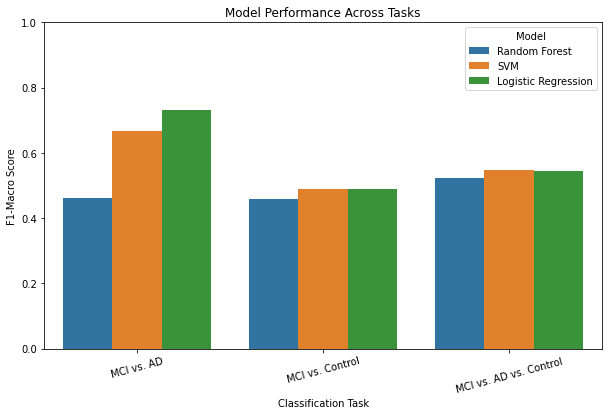

In [4]:
results_df = pd.DataFrame(results)

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=results_df,
    x="Task",
    y="Mean F1 Macro",
    hue="Model",
    capsize=0.1,
    errwidth=1.5
)

plt.ylim(0, 1)
plt.ylabel("F1-Macro Score")
plt.xlabel("Classification Task")
plt.title("Model Performance Across Tasks")
plt.xticks(rotation=15)
plt.legend(title="Model")
plt.show()